In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, rfft
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import lightgbm as lgb
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from sklearn.preprocessing import StandardScaler
import seaborn
import tensorflow as tf

In [199]:
data = pd.read_csv('/kaggle/input/midterm-2-dataset/data.csv',index_col=0, parse_dates=True).sort_index()
next_day_forecast = pd.read_csv('/kaggle/input/midterm-2-dataset/load_forecast_next_day.csv', index_col=0, parse_dates=True).sort_index()
weather = pd.read_csv('/kaggle/input/midterm-2-dataset/weather.csv', index_col=0, parse_dates=True).sort_index()

In [200]:
data

RTO COMBINED - LOAD_FORECAST
DATETIME                                         
2021-01-01 01:00:00                         82410
2021-01-01 02:00:00                         80705
2021-01-01 03:00:00                         79378
2021-01-01 04:00:00                         79332
2021-01-01 05:00:00                         79747
...                                           ...
2023-04-06 20:00:00                         89534
2023-04-06 21:00:00                         88571
2023-04-06 22:00:00                         85232
2023-04-06 23:00:00                         80595
2023-04-07 00:00:00                         76077

[19947 rows x 1 columns]

In [201]:
next_day_forecast

load_forecast
2023-04-07 01:00:00          71600
2023-04-07 02:00:00          68905
2023-04-07 03:00:00          67438
2023-04-07 04:00:00          67068
2023-04-07 05:00:00          67492
2023-04-07 06:00:00          70273
2023-04-07 07:00:00          74673
2023-04-07 08:00:00          78066
2023-04-07 09:00:00          80446
2023-04-07 10:00:00          81613
2023-04-07 11:00:00          81996
2023-04-07 12:00:00          81142
2023-04-07 13:00:00          80487
2023-04-07 14:00:00          80299
2023-04-07 15:00:00          79471
2023-04-07 16:00:00          78653
2023-04-07 17:00:00          78901
2023-04-07 18:00:00          79435
2023-04-07 19:00:00          79438
2023-04-07 20:00:00          80277
2023-04-07 21:00:00          82159
2023-04-07 22:00:00          81034
2023-04-07 23:00:00          78447
2023-04-08 00:00:00          75346

In [202]:
weather

DC - Washington/Reagan Arpt - TEMP  \
DATETIME                                                  
2021-01-01 01:00:00                               39.00   
2021-01-01 02:00:00                               38.00   
2021-01-01 03:00:00                               38.00   
2021-01-01 04:00:00                               37.00   
2021-01-01 05:00:00                               36.00   
...                                                 ...   
2023-04-06 20:00:00                               72.14   
2023-04-06 21:00:00                               66.72   
2023-04-06 22:00:00                               64.58   
2023-04-06 23:00:00                               61.32   
2023-04-07 00:00:00                               59.72   

                     PA - Pittsburgh/Intl - TEMP  \
DATETIME                                           
2021-01-01 01:00:00                        28.00   
2021-01-01 02:00:00                        28.00   
2021-01-01 03:00:00                        27.00   
2021-01-01 04:00:00                        27.00   
2021-01-01 05:00:00                        27.00   
...                                          ...   
2023-04-06 20:00:00                        50.36   
2023-04-06 21:00:00                        49.80   
2023-04-06 22:00:00                        47.84   
2023-04-06 23:00:00                        46.22   
2023-04-07 00:00:00                        43.70   

                     PA - Philadelphia/Intl - TEMP  \
DATETIME                                             
2021-01-01 01:00:00                          36.00   
2021-01-01 02:00:00                          34.00   
2021-01-01 03:00:00                          34.00   
2021-01-01 04:00:00                          33.00   
2021-01-01 05:00:00                          32.00   
...                                            ...   
2023-04-06 20:00:00                          76.99   
2023-04-06 21:00:00                          70.44   
2023-04-06 22:00:00                          65.12   
2023-04-06 23:00:00                          61.70   
2023-04-07 00:00:00                          60.26   

                     OH - Cleveland/Hopkins/NWSFO - TEMP  \
DATETIME                                                   
2021-01-01 01:00:00                                28.00   
2021-01-01 02:00:00                                27.00   
2021-01-01 03:00:00                                27.00   
2021-01-01 04:00:00                                27.00   
2021-01-01 05:00:00                                26.00   
...                                                  ...   
2023-04-06 20:00:00                                50.18   
2023-04-06 21:00:00                                47.84   
2023-04-06 22:00:00                                45.86   
2023-04-06 23:00:00                                44.78   
2023-04-07 00:00:00                                43.88   

                     IL - Chicago/O'Hare Intl - TEMP  \
DATETIME                                               
2021-01-01 01:00:00                            24.00   
2021-01-01 02:00:00                            24.00   
2021-01-01 03:00:00                            24.00   
2021-01-01 04:00:00                            25.00   
2021-01-01 05:00:00                            22.00   
...                                              ...   
2023-04-06 20:00:00                            49.28   
2023-04-06 21:00:00                            46.94   
2023-04-06 22:00:00                            44.96   
2023-04-06 23:00:00                            43.52   
2023-04-07 00:00:00                            42.44   

                     DC - Washington/Reagan Arpt - RH  \
DATETIME                                                
2021-01-01 01:00:00                              69.0   
2021-01-01 02:00:00                              69.0   
2021-01-01 03:00:00                              69.0   
2021-01-01 04:00:00                              69.0   
2021-01-01 05:00:00  

In [203]:
def create_features(df):
    """
    Creates time series features from datetime index and returns a DataFrame with the new features.
    """
    operations = [
        ('hour', 'hour'),
        ('dayofweek', 'dayofweek'),
        ('quarter', 'quarter'),
        ('month', 'month'),
        ('year', 'year'),
        ('dayofyear', 'dayofyear'),
        ('dayofmonth', 'day'),
        ('weekofyear', 'week') 
    ]

    for col, op in operations:
        df[col] = getattr(df.index.to_series().dt, op)

    return df

<AxesSubplot:xlabel='DATETIME'>

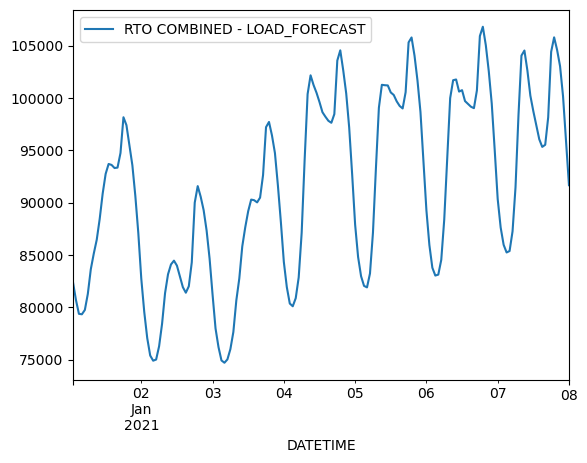

In [204]:
data.head(24*7).plot()

In [205]:
fft = tf.signal.rfft(data['RTO COMBINED - LOAD_FORECAST'])
fft

<tf.Tensor: shape=(9974,), dtype=complex64, numpy=
array([ 1.8028357e+09+3.9179688e+02j, -6.9932650e+06+9.5502200e+05j,
       -1.6023708e+07+8.9428119e+05j, ..., -2.0051764e+05-5.8806766e+04j,
       -8.4401984e+04-1.6164425e+05j,  2.4618381e+04-6.1911715e+04j],
      dtype=complex64)>

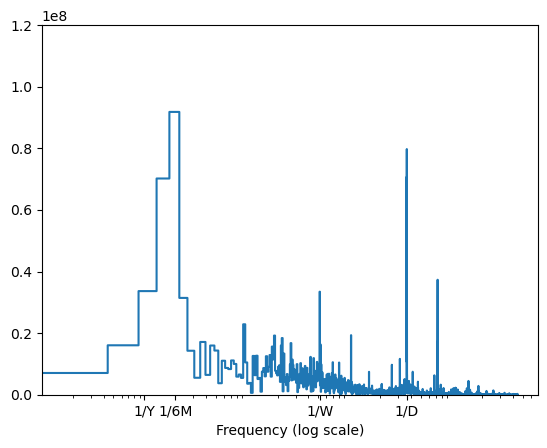

In [206]:
fft = tf.signal.rfft(data['RTO COMBINED - LOAD_FORECAST'])
f_per_dataset = np.arange(0, len(fft))
n_samples_h = len(data)
hours_per_year = 24 * 365.2524
years_per_dataset = n_samples_h / (hours_per_year)

f_per_year = f_per_dataset / years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale("log")
plt.ylim(0, 1.2e8)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 2, 52, 365.2524], labels=["1/Y", "1/6M", "1/W", "1/D"])
_ = plt.xlabel("Frequency (log scale)")

In [ ]:
def adf_test(time_series):
    print('Results of the Dickey Fuller Test for testing stationarity')
    dftest = adfuller(time_series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
adf_test(data['RTO COMBINED - LOAD_FORECAST'])

Based on the p-value of 0.005 of the Augmented Dickey Fuller test, it can be concluded that the time series shows stationarity

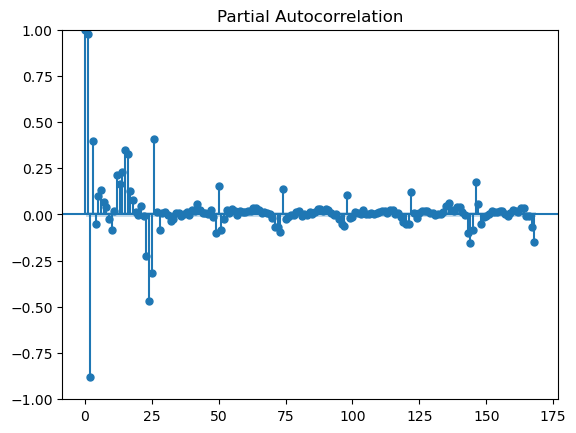

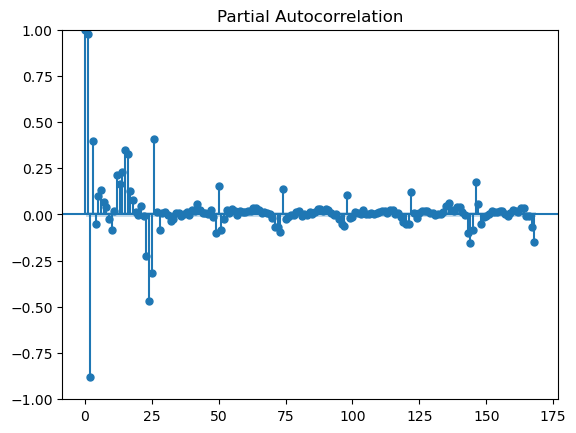

In [207]:
plot_pacf(data['RTO COMBINED - LOAD_FORECAST'], method='ywm', lags=24*7)

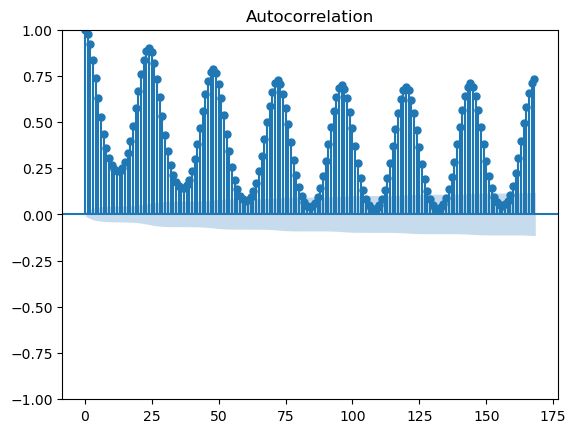

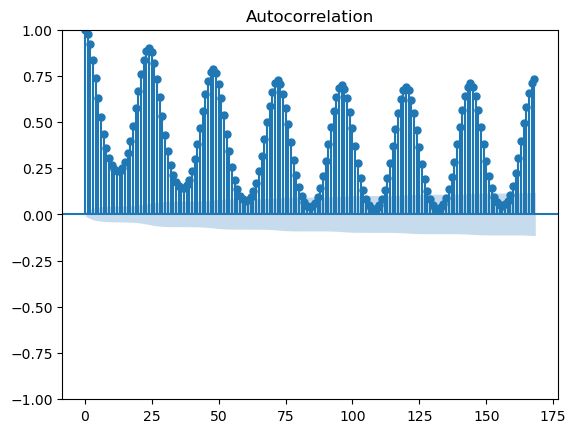

In [208]:
plot_acf(data['RTO COMBINED - LOAD_FORECAST'], lags=24*7)

In [ ]:
!pip install pmdarima

In [ ]:
import pmdarima as pm
model = pm.auto_arima(data['RTO COMBINED - LOAD_FORECAST'], D=1, start_P=1, max_P=1, start_Q=0, max_Q=0, seasonal=True, m=24, 
                      stationary=True, d=1, start_p=1, max_p=3, start_q=1, max_q=3)
model.summary()

In [209]:
sarima_model = SARIMAX(endog=data['RTO COMBINED - LOAD_FORECAST'], order=(3,0,0), seasonal_order=(1,0,0,24), simple_differencing=True)
res = sarima_model.fit(disp=False)
print(res.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                     SARIMAX Results                                      
Dep. Variable:       RTO COMBINED - LOAD_FORECAST   No. Observations:                19947
Model:             SARIMAX(3, 0, 0)x(1, 0, 0, 24)   Log Likelihood             -163384.774
Date:                            Wed, 26 Apr 2023   AIC                         326779.548
Time:                                    20:27:48   BIC                         326819.052
Sample:                                         0   HQIC                        326792.474
                                          - 19947                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6641      0.005    330.375      0.000       1.654       1.674
ar.L2         -0.7279      0.009   

In [ ]:
res.plot_diagnostics(figsize=(16, 8))
plt.show()

In [210]:
next_day_forecast_pred = res.forecast(24)
next_day_forecast_pred = np.array(next_day_forecast_pred)
next_day_forecast_pred

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


array([72860.22382894, 70424.77371984, 68712.61503177, 68043.67920879,
       68545.75531312, 71101.42470611, 75976.57640385, 79989.74664324,
       81754.94957954, 82382.33527955, 83016.02757853, 83373.95418405,
       84442.80280829, 84953.95261153, 85138.61305381, 85084.37880685,
       85202.21554343, 85335.81853895, 85318.56137504, 85152.59216569,
       84153.7823793 , 80934.85775621, 76505.94524655, 72195.04464877])

In [211]:
next_day_forecast_true = np.array(next_day_forecast['load_forecast'])

In [212]:
next_day_forecast_true

array([71600, 68905, 67438, 67068, 67492, 70273, 74673, 78066, 80446,
       81613, 81996, 81142, 80487, 80299, 79471, 78653, 78901, 79435,
       79438, 80277, 82159, 81034, 78447, 75346])

In [213]:
mape_error_sarima = np.mean(np.abs((next_day_forecast_true - next_day_forecast_pred)/next_day_forecast_true)*100)
rmse_sarima = np.sqrt(np.mean((next_day_forecast_true - next_day_forecast_pred)**2))
mae_sarima = mean_absolute_error(next_day_forecast_true, next_day_forecast_pred)
print(f'MAPE: {mape_error_sarima}%')
print(f'RMSE: {rmse_sarima}')
print(f'MAE: {mae_sarima}')

MAPE: 3.5392940170951337%
RMSE: 3436.098679120796
MAE: 2763.4971295273263


In [10]:
weather

DC - Washington/Reagan Arpt - TEMP  \
DATETIME                                                  
2021-01-01 01:00:00                               39.00   
2021-01-01 02:00:00                               38.00   
2021-01-01 03:00:00                               38.00   
2021-01-01 04:00:00                               37.00   
2021-01-01 05:00:00                               36.00   
...                                                 ...   
2023-04-06 20:00:00                               72.14   
2023-04-06 21:00:00                               66.72   
2023-04-06 22:00:00                               64.58   
2023-04-06 23:00:00                               61.32   
2023-04-07 00:00:00                               59.72   

                     PA - Pittsburgh/Intl - TEMP  \
DATETIME                                           
2021-01-01 01:00:00                        28.00   
2021-01-01 02:00:00                        28.00   
2021-01-01 03:00:00                        27.00   
2021-01-01 04:00:00                        27.00   
2021-01-01 05:00:00                        27.00   
...                                          ...   
2023-04-06 20:00:00                        50.36   
2023-04-06 21:00:00                        49.80   
2023-04-06 22:00:00                        47.84   
2023-04-06 23:00:00                        46.22   
2023-04-07 00:00:00                        43.70   

                     PA - Philadelphia/Intl - TEMP  \
DATETIME                                             
2021-01-01 01:00:00                          36.00   
2021-01-01 02:00:00                          34.00   
2021-01-01 03:00:00                          34.00   
2021-01-01 04:00:00                          33.00   
2021-01-01 05:00:00                          32.00   
...                                            ...   
2023-04-06 20:00:00                          76.99   
2023-04-06 21:00:00                          70.44   
2023-04-06 22:00:00                          65.12   
2023-04-06 23:00:00                          61.70   
2023-04-07 00:00:00                          60.26   

                     OH - Cleveland/Hopkins/NWSFO - TEMP  \
DATETIME                                                   
2021-01-01 01:00:00                                28.00   
2021-01-01 02:00:00                                27.00   
2021-01-01 03:00:00                                27.00   
2021-01-01 04:00:00                                27.00   
2021-01-01 05:00:00                                26.00   
...                                                  ...   
2023-04-06 20:00:00                                50.18   
2023-04-06 21:00:00                                47.84   
2023-04-06 22:00:00                                45.86   
2023-04-06 23:00:00                                44.78   
2023-04-07 00:00:00                                43.88   

                     IL - Chicago/O'Hare Intl - TEMP  \
DATETIME                                               
2021-01-01 01:00:00                            24.00   
2021-01-01 02:00:00                            24.00   
2021-01-01 03:00:00                            24.00   
2021-01-01 04:00:00                            25.00   
2021-01-01 05:00:00                            22.00   
...                                              ...   
2023-04-06 20:00:00                            49.28   
2023-04-06 21:00:00                            46.94   
2023-04-06 22:00:00                            44.96   
2023-04-06 23:00:00                            43.52   
2023-04-07 00:00:00                            42.44   

                     DC - Washington/Reagan Arpt - RH  \
DATETIME                                                
2021-01-01 01:00:00                              69.0   
2021-01-01 02:00:00                              69.0   
2021-01-01 03:00:00                              69.0   
2021-01-01 04:00:00                              69.0   
2021-01-01 05:00:00  

In [11]:
weather.columns

Index(['DC - Washington/Reagan Arpt - TEMP', 'PA - Pittsburgh/Intl - TEMP',
       'PA - Philadelphia/Intl - TEMP', 'OH - Cleveland/Hopkins/NWSFO - TEMP',
       'IL - Chicago/O'Hare Intl - TEMP', 'DC - Washington/Reagan Arpt - RH',
       'PA - Pittsburgh/Intl - RH', 'PA - Philadelphia/Intl - RH',
       'OH - Cleveland/Hopkins/NWSFO - RH', 'IL - Chicago/O'Hare Intl - RH',
       'DC - Washington/Reagan Arpt - CLDC', 'PA - Pittsburgh/Intl - CLDC',
       'PA - Philadelphia/Intl - CLDC', 'OH - Cleveland/Hopkins/NWSFO - CLDC',
       'IL - Chicago/O'Hare Intl - CLDC', 'DC - Washington/Reagan Arpt - WIND',
       'PA - Pittsburgh/Intl - WIND', 'PA - Philadelphia/Intl - WIND',
       'OH - Cleveland/Hopkins/NWSFO - WIND',
       'IL - Chicago/O'Hare Intl - WIND', 'DC - Washington/Reagan Arpt - PRCP',
       'PA - Pittsburgh/Intl - PRCP', 'PA - Philadelphia/Intl - PRCP',
       'OH - Cleveland/Hopkins/NWSFO - PRCP',
       'IL - Chicago/O'Hare Intl - PRCP', 'DC - Washington/Reagan Arpt - D

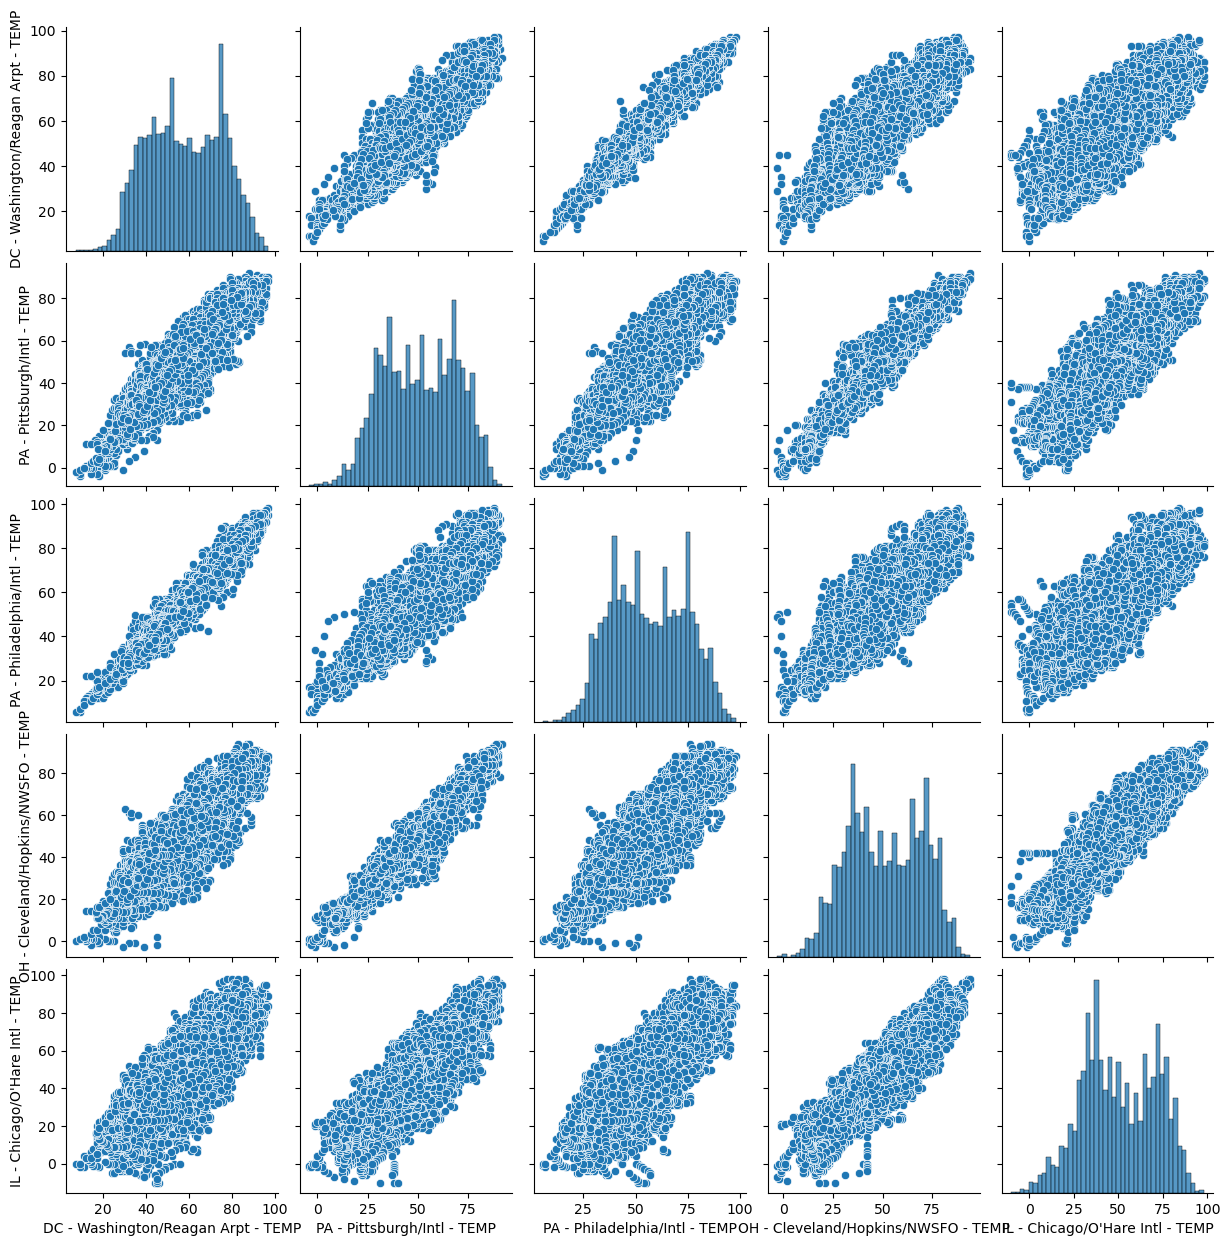

In [12]:
#fig = plt.figure()
fig = seaborn.pairplot(weather.iloc[:,0:5])
plt.show()
fig.savefig('temp_plot_dataset.png')

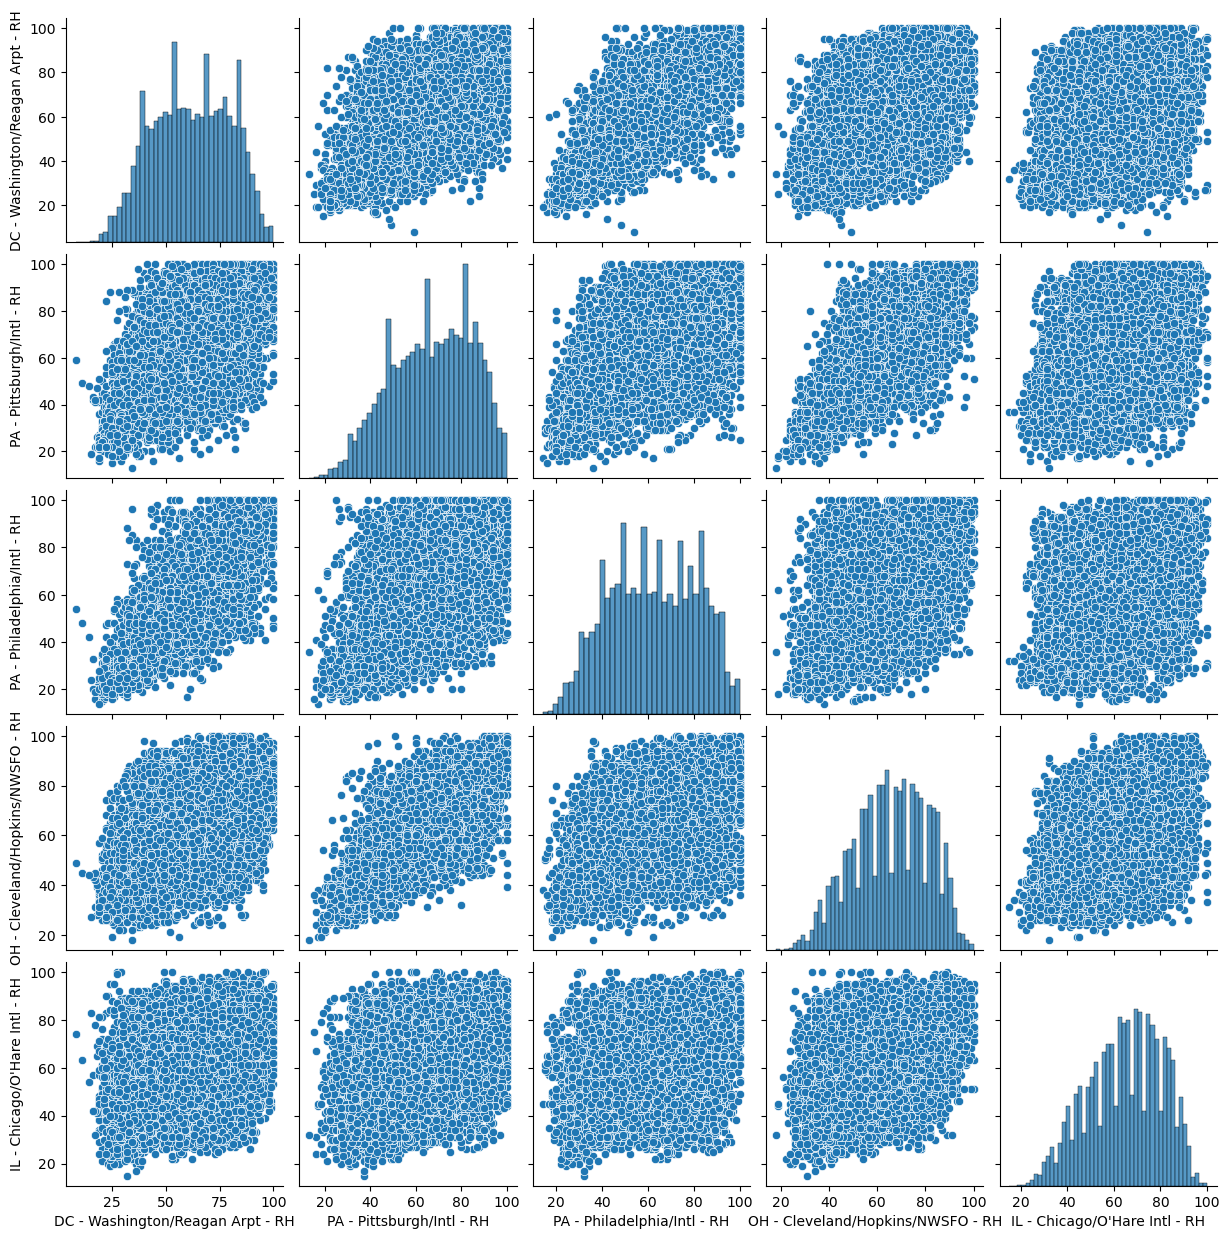

In [13]:
fig = seaborn.pairplot(weather.iloc[:,5:10])
plt.show()
fig.savefig('rh_plot_dataset.png')

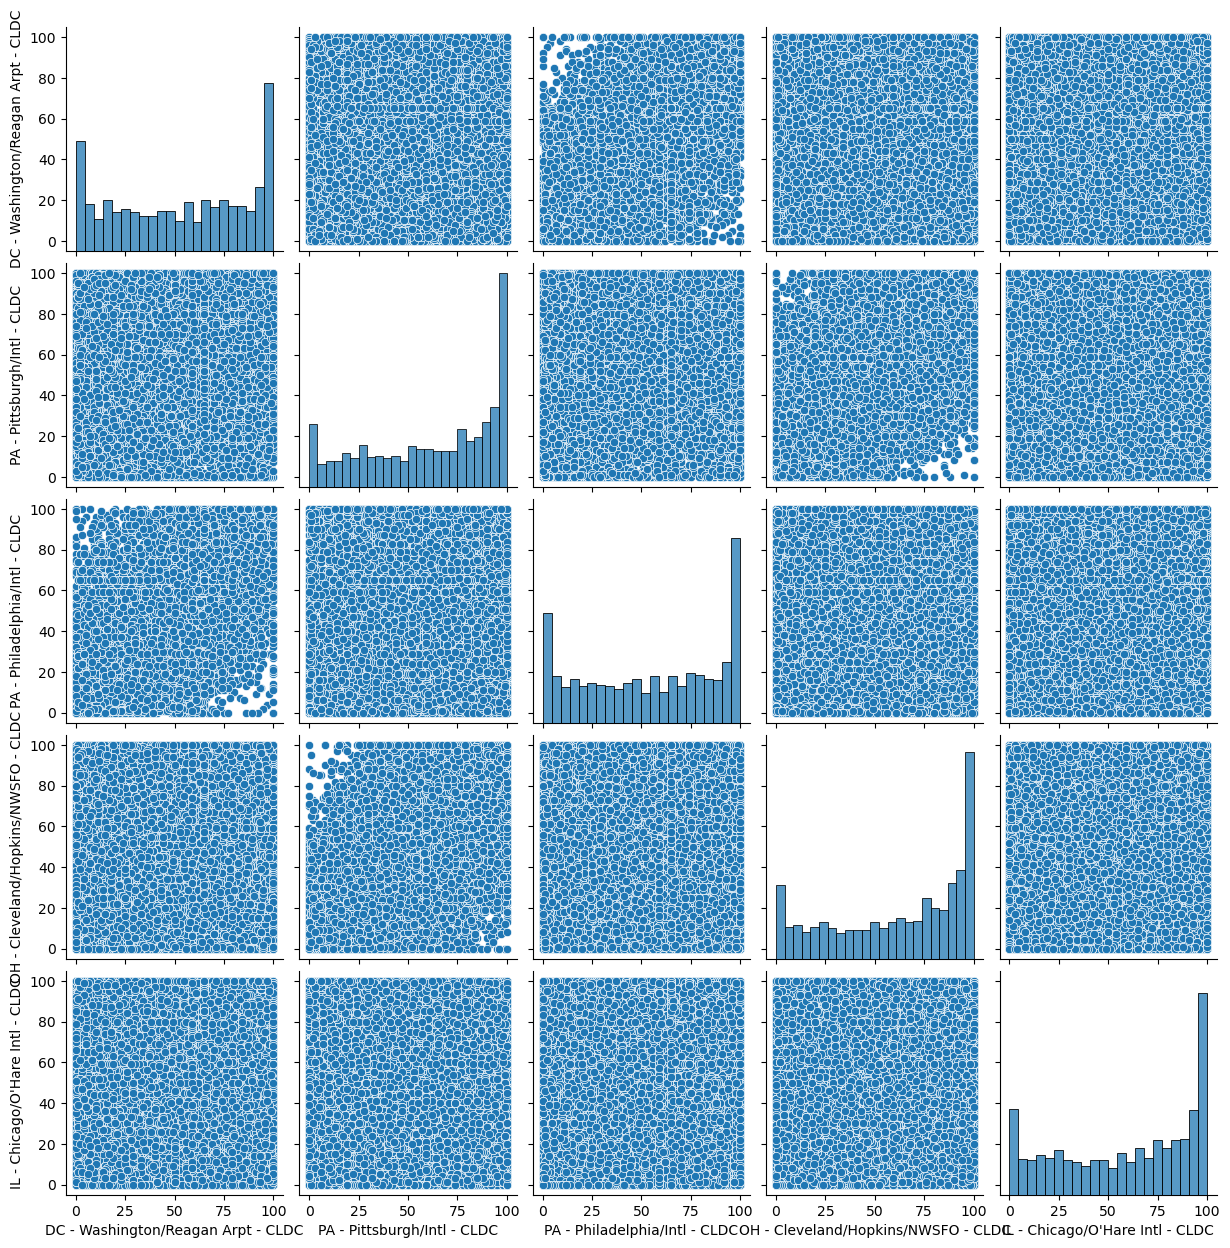

In [14]:
fig = seaborn.pairplot(weather.iloc[:,10:15])
plt.show()
fig.savefig('cldc_plot_dataset.png')

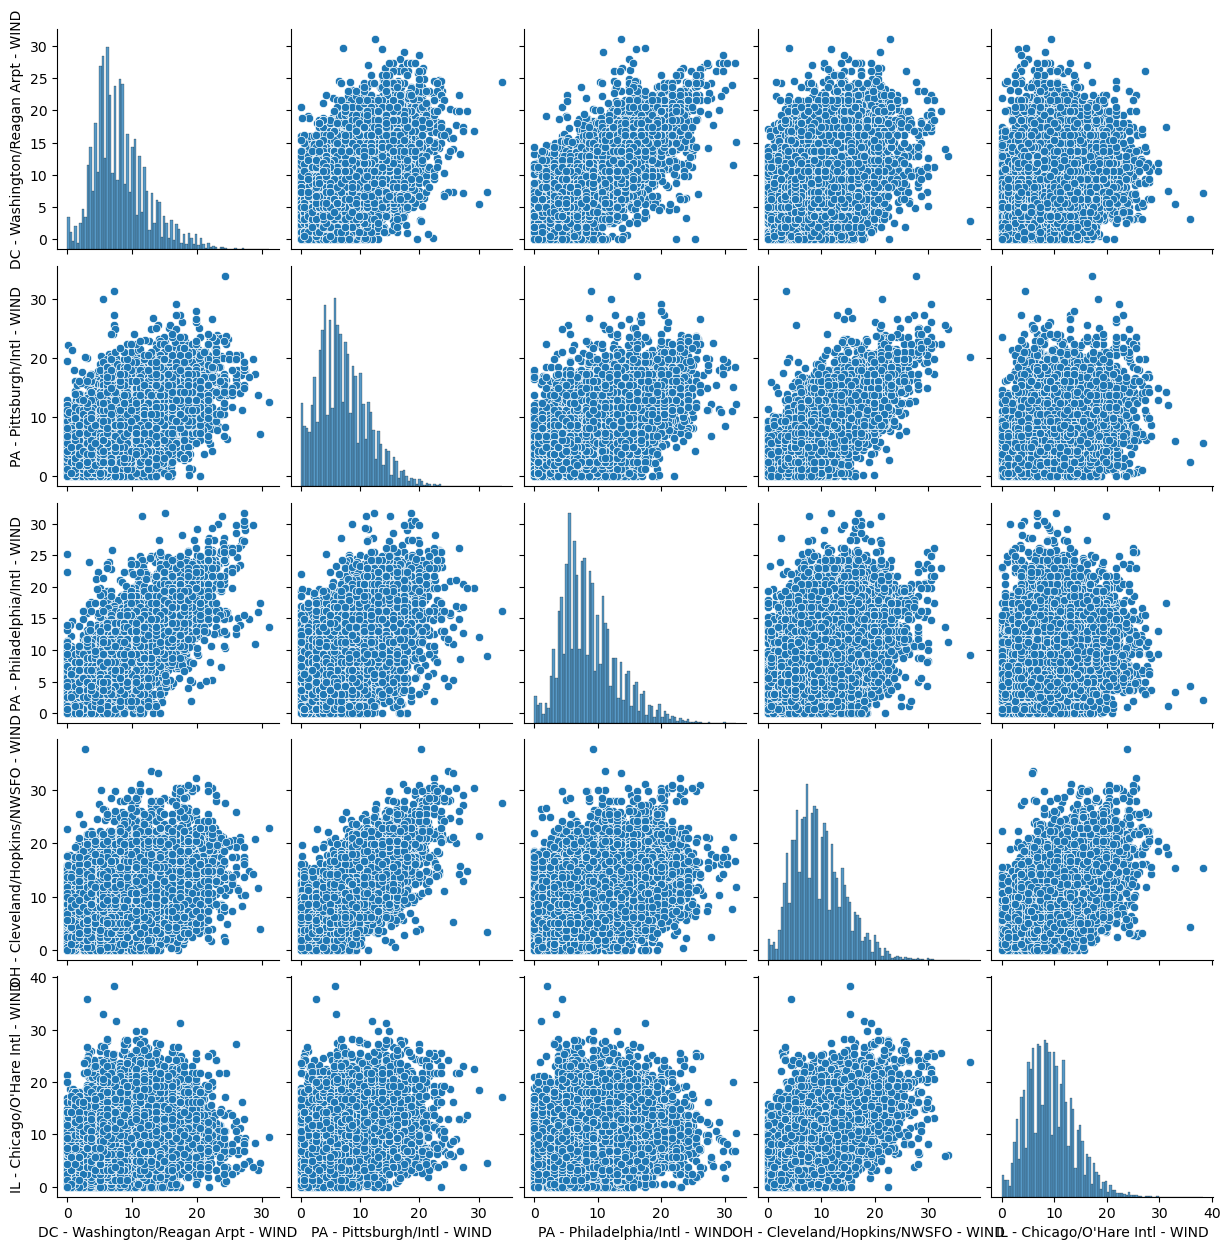

In [15]:
fig = seaborn.pairplot(weather.iloc[:,15:20])
plt.show()
fig.savefig('wind_plot_dataset.png')

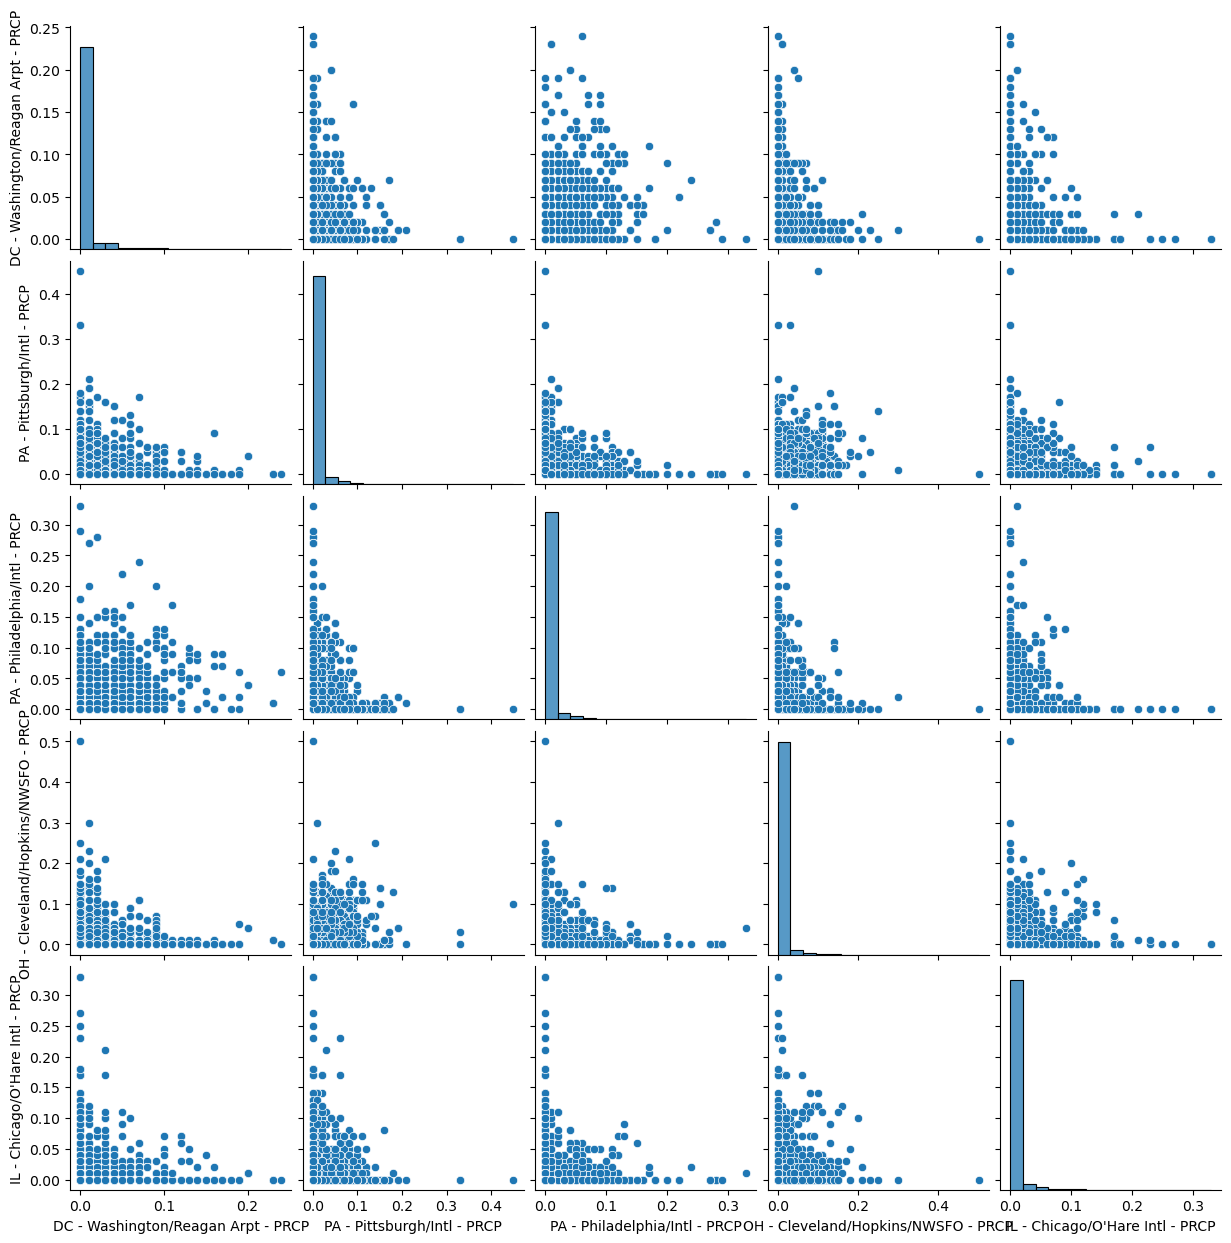

In [16]:
fig = seaborn.pairplot(weather.iloc[:,20:25])
plt.show()
fig.savefig('PRCP_plot_dataset.png')

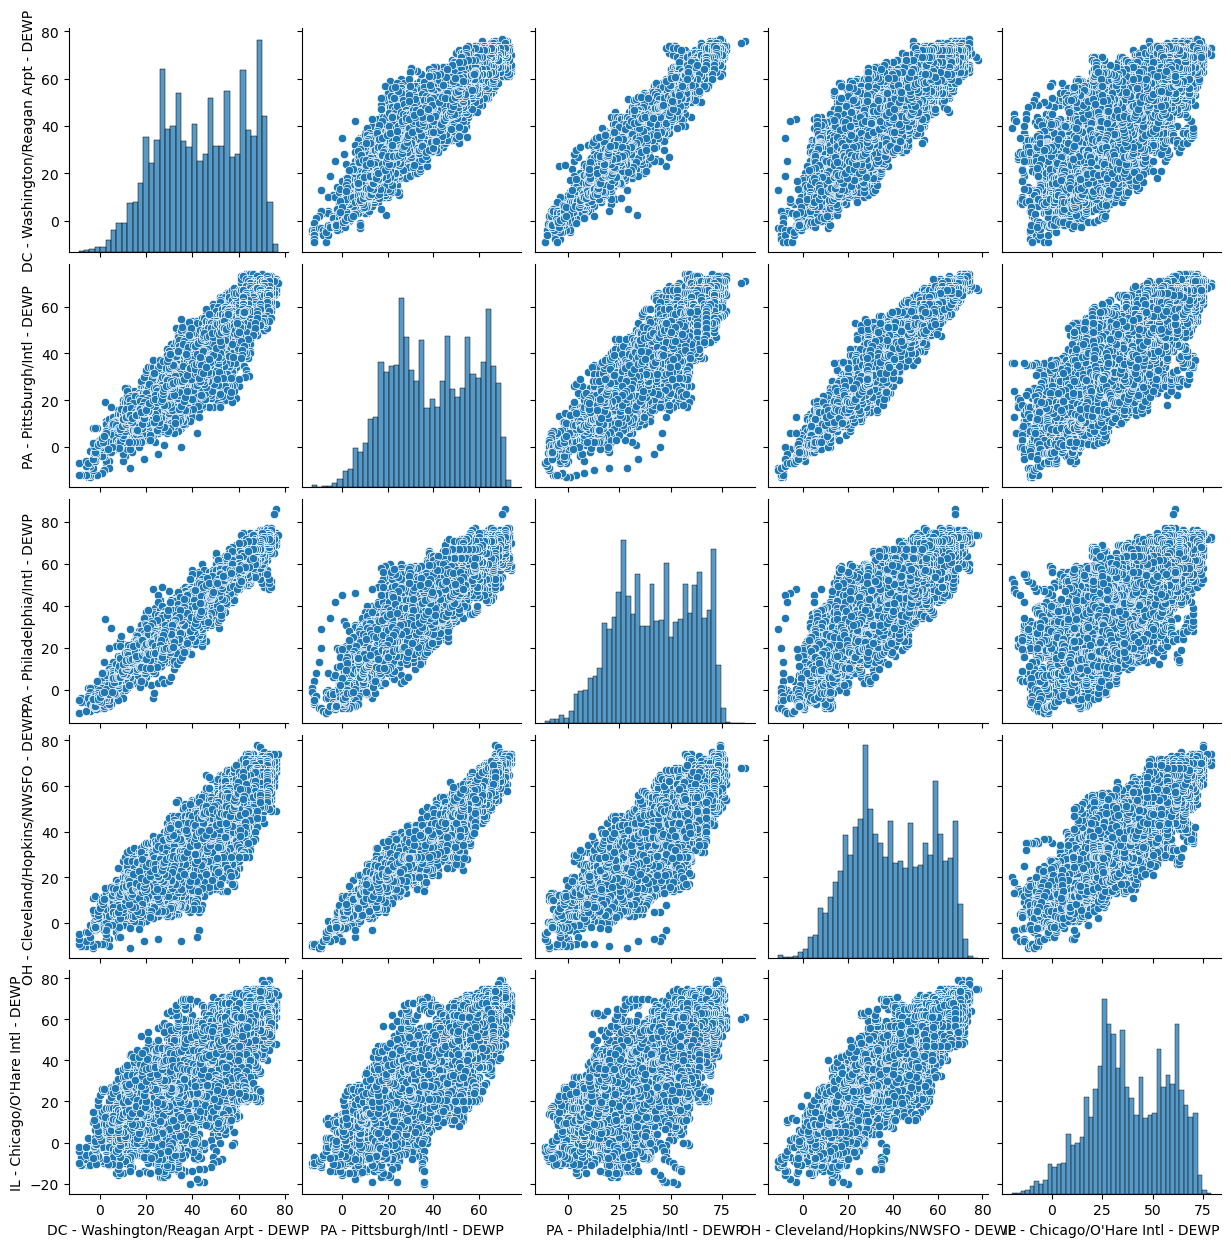

In [17]:
fig = seaborn.pairplot(weather.iloc[:,25:30])
plt.show()
fig.savefig('DEWP_dataset.png')

In [7]:
skewness = data.skew()

In [8]:
skewness = list(skewness)
skewness

[0.7472950117985941]

In [9]:
df_data_copy = data.copy()

In [132]:
scaler = StandardScaler()
X_train = weather['2021-01-01':'2022-06-01']
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_train_scaled

DC - Washington/Reagan Arpt - TEMP  \
DATETIME                                                  
2021-01-01 01:00:00                           -1.055130   
2021-01-01 02:00:00                           -1.113166   
2021-01-01 03:00:00                           -1.113166   
2021-01-01 04:00:00                           -1.171202   
2021-01-01 05:00:00                           -1.229239   
...                                                 ...   
2022-06-01 19:00:00                            2.020790   
2022-06-01 20:00:00                            1.904717   
2022-06-01 21:00:00                            1.788645   
2022-06-01 22:00:00                            1.672573   
2022-06-01 23:00:00                            1.556500   

                     PA - Pittsburgh/Intl - TEMP  \
DATETIME                                           
2021-01-01 01:00:00                    -1.186980   
2021-01-01 02:00:00                    -1.186980   
2021-01-01 03:00:00                    -1.240428   
2021-01-01 04:00:00                    -1.240428   
2021-01-01 05:00:00                    -1.240428   
...                                          ...   
2022-06-01 19:00:00                     1.806107   
2022-06-01 20:00:00                     1.699211   
2022-06-01 21:00:00                     1.538867   
2022-06-01 22:00:00                     1.431971   
2022-06-01 23:00:00                     1.271627   

                     PA - Philadelphia/Intl - TEMP  \
DATETIME                                             
2021-01-01 01:00:00                      -1.097910   
2021-01-01 02:00:00                      -1.212411   
2021-01-01 03:00:00                      -1.212411   
2021-01-01 04:00:00                      -1.269661   
2021-01-01 05:00:00                      -1.326912   
...                                            ...   
2022-06-01 19:00:00                       1.650109   
2022-06-01 20:00:00                       1.478358   
2022-06-01 21:00:00                       1.306607   
2022-06-01 22:00:00                       1.020355   
2022-06-01 23:00:00                       0.963104   

                     OH - Cleveland/Hopkins/NWSFO - TEMP  \
DATETIME                                                   
2021-01-01 01:00:00                            -1.152367   
2021-01-01 02:00:00                            -1.204635   
2021-01-01 03:00:00                            -1.204635   
2021-01-01 04:00:00                            -1.204635   
2021-01-01 05:00:00                            -1.256902   
...                                                  ...   
2022-06-01 19:00:00                             1.408742   
2022-06-01 20:00:00                             1.199671   
2022-06-01 21:00:00                             1.042869   
2022-06-01 22:00:00                             1.199671   
2022-06-01 23:00:00                             1.147404   

                     IL - Chicago/O'Hare Intl - TEMP  \
DATETIME                                               
2021-01-01 01:00:00                        -1.229941   
2021-01-01 02:00:00                        -1.229941   
2021-01-01 03:00:00                        -1.229941   
2021-01-01 04:00:00                        -1.181862   
2021-01-01 05:00:00                        -1.326099   
...                                              ...   
2022-06-01 19:00:00                         0.837451   
2022-06-01 20:00:00                         0.789372   
2022-06-01 21:00:00                         0.693214   
2022-06-01 22:00:00                         0.645136   
2022-06-01 23:00:00                         0.548978   

                     DC - Washington/Reagan Arpt - RH  \
DATETIME                                                
2021-01-01 01:00:00                          0.463278   
2021-01-01 02:00:00                          0.463278   
2021-01-01 03:00:00                          0.463278   
2021-01-01 04:00:00                          0.463278   
2021-01-01 05:00:00  

In [11]:
data['RTO COMBINED - LOAD_FORECAST'] = np.log(data['RTO COMBINED - LOAD_FORECAST'])

In [133]:
y_train = data['2021-01-01':'2022-06-01']['RTO COMBINED - LOAD_FORECAST']
y_train

DATETIME
2021-01-01 01:00:00    11.319462
2021-01-01 02:00:00    11.298556
2021-01-01 03:00:00    11.281977
2021-01-01 04:00:00    11.281397
2021-01-01 05:00:00    11.286614
                         ...    
2022-06-01 19:00:00    11.723300
2022-06-01 20:00:00    11.684750
2022-06-01 21:00:00    11.641310
2022-06-01 22:00:00    11.601595
2022-06-01 23:00:00    11.528818
Name: RTO COMBINED - LOAD_FORECAST, Length: 12468, dtype: float64

In [134]:
X_test = weather['2022-06-01':]
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
X_test_scaled

DC - Washington/Reagan Arpt - TEMP  \
DATETIME                                                  
2022-06-01 00:00:00                            1.440428   
2022-06-01 01:00:00                            1.382391   
2022-06-01 02:00:00                            1.266319   
2022-06-01 03:00:00                            1.208283   
2022-06-01 04:00:00                            1.150247   
...                                                 ...   
2023-04-06 20:00:00                            0.868190   
2023-04-06 21:00:00                            0.553634   
2023-04-06 22:00:00                            0.429437   
2023-04-06 23:00:00                            0.240239   
2023-04-07 00:00:00                            0.147381   

                     PA - Pittsburgh/Intl - TEMP  \
DATETIME                                           
2022-06-01 00:00:00                     1.325075   
2022-06-01 01:00:00                     1.218179   
2022-06-01 02:00:00                     1.164731   
2022-06-01 03:00:00                     1.111283   
2022-06-01 04:00:00                     1.004387   
...                                          ...   
2023-04-06 20:00:00                     0.008117   
2023-04-06 21:00:00                    -0.021814   
2023-04-06 22:00:00                    -0.126572   
2023-04-06 23:00:00                    -0.213158   
2023-04-07 00:00:00                    -0.347846   

                     PA - Philadelphia/Intl - TEMP  \
DATETIME                                             
2022-06-01 00:00:00                       1.535608   
2022-06-01 01:00:00                       1.421108   
2022-06-01 02:00:00                       1.363857   
2022-06-01 03:00:00                       1.306607   
2022-06-01 04:00:00                       1.249356   
...                                            ...   
2023-04-06 20:00:00                       1.248784   
2023-04-06 21:00:00                       0.873794   
2023-04-06 22:00:00                       0.569222   
2023-04-06 23:00:00                       0.373425   
2023-04-07 00:00:00                       0.290985   

                     OH - Cleveland/Hopkins/NWSFO - TEMP  \
DATETIME                                                   
2022-06-01 00:00:00                             1.461009   
2022-06-01 01:00:00                             1.356474   
2022-06-01 02:00:00                             1.356474   
2022-06-01 03:00:00                             1.304206   
2022-06-01 04:00:00                             1.251939   
...                                                  ...   
2023-04-06 20:00:00                             0.006926   
2023-04-06 21:00:00                            -0.115380   
2023-04-06 22:00:00                            -0.218869   
2023-04-06 23:00:00                            -0.275318   
2023-04-07 00:00:00                            -0.322359   

                     IL - Chicago/O'Hare Intl - TEMP  \
DATETIME                                               
2022-06-01 00:00:00                         1.222082   
2022-06-01 01:00:00                         1.125925   
2022-06-01 02:00:00                         1.029767   
2022-06-01 03:00:00                         1.029767   
2022-06-01 04:00:00                         0.981688   
...                                              ...   
2023-04-06 20:00:00                        -0.014507   
2023-04-06 21:00:00                        -0.127011   
2023-04-06 22:00:00                        -0.222208   
2023-04-06 23:00:00                        -0.291441   
2023-04-07 00:00:00                        -0.343366   

                     DC - Washington/Reagan Arpt - RH  \
DATETIME                                                
2022-06-01 00:00:00                          0.016735   
2022-06-01 01:00:00                          0.240006   
2022-06-01 02:00:00                          0.351642   
2022-06-01 03:00:00                          0.463278   
2022-06-01 04:00:00  

In [135]:
y_test = data['2022-06-01':]['RTO COMBINED - LOAD_FORECAST']
y_test

DATETIME
2022-06-01 00:00:00    11.564787
2022-06-01 01:00:00    11.469893
2022-06-01 02:00:00    11.406420
2022-06-01 03:00:00    11.357627
2022-06-01 04:00:00    11.317981
                         ...    
2023-04-06 20:00:00    11.402374
2023-04-06 21:00:00    11.391560
2023-04-06 22:00:00    11.353132
2023-04-06 23:00:00    11.297192
2023-04-07 00:00:00    11.239501
Name: RTO COMBINED - LOAD_FORECAST, Length: 7503, dtype: float64

In [136]:
lgb_train = lgb.Dataset(X_train_scaled, y_train)
lgb_train

In [137]:
lgb_eval =  lgb.Dataset(X_test_scaled, y_test, reference=lgb_train)
lgb_eval

In [138]:
params = {
    'boosting_type':'gbdt',
    'objective':'regression',
    'metric':{'l2','l1'},
    'num_leaves': 41,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose':0
}
print('Training....')
gbm =  lgb.train(params, lgb_train, num_boost_round=20, valid_sets=lgb_eval, callbacks=[lgb.early_stopping(stopping_rounds=5)])
print('Saving Model....')
gbm.save_model('model.txt')
print('Running Inference....')
y_pred = gbm.predict(X_test_scaled, num_iteration=gbm.best_iteration)

Training....
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's l2: 0.0105854	valid_0's l1: 0.085267
Saving Model....
Running Inference....


In [139]:
y_test = np.array(y_test)
y_test

array([11.5647871 , 11.4698927 , 11.40641985, ..., 11.35313223,
       11.29719189, 11.23950126])

In [140]:
y_pred

array([11.51599695, 11.48841609, 11.4530034 , ..., 11.32398747,
       11.32398747, 11.32285947])

In [141]:
y_train = np.array(y_train)
y_train

array([11.31946207, 11.29855581, 11.28197653, ..., 11.64130988,
       11.60159547, 11.5288185 ])

In [142]:
y_pred_in_samples = gbm.predict(X_train_scaled, num_iteration=gbm.best_iteration)
mape_lgbm_in_sample = mean_absolute_percentage_error(np.exp(y_train), np.exp(y_pred_in_samples))
mae_lgbm_in_sample = mean_absolute_error(np.exp(y_train), np.exp(y_pred_in_samples))
rmse_train = mean_squared_error(np.exp(y_train), np.exp(y_pred_in_samples))**0.5
print(f'RMSE of in samples using LightGBM regressor is {rmse_train}')
print(f'In sample MAPE: {mape_lgbm_in_sample*100}%')
print(f'In sample MAE: {mae_lgbm_in_sample}')

RMSE of in samples using LightGBM regressor is 8948.768437174449
In sample MAPE: 8.117728505565298%
In sample MAE: 7226.4659874702775


In [143]:
mape_lgbm_out_of_sample = mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred))#np.mean(np.abs((y_test - y_pred)/y_test)*100)
mae_lgbm_out_of_sample = mean_absolute_error(np.exp(y_test), np.exp(y_pred))
rmse_test = mean_squared_error(np.exp(y_test), np.exp(y_pred))**0.5
print(f'RMSE of prediction using LightGBM regressor is: {rmse_test}')
print(f'Out of sample MAPE: {mape_lgbm_out_of_sample*100}%')
print(f'Out of sample MAE: {mae_lgbm_out_of_sample}')

RMSE of prediction using LightGBM regressor is: 9744.03456582235
Out of sample MAPE: 8.45602652949147%
Out of sample MAE: 7836.499419199737


In [144]:
y_out_of_sample_truth_24 = y_test[-24:]
y_out_of_sample_truth_24

array([11.20257506, 11.16516779, 11.13977265, 11.13151862, 11.14225301,
       11.18418526, 11.257065  , 11.31385238, 11.33940506, 11.35002999,
       11.36048499, 11.36728679, 11.38256618, 11.39076913, 11.39485114,
       11.39591963, 11.39891655, 11.40197156, 11.4031106 , 11.40237372,
       11.39155977, 11.35313223, 11.29719189, 11.23950126])

In [145]:
y_pred[-24:]

array([11.30767897, 11.30972215, 11.30809377, 11.30272613, 11.31219879,
       11.29537574, 11.30125109, 11.30134933, 11.30221368, 11.2974921 ,
       11.30580722, 11.34497236, 11.39690218, 11.43260824, 11.43686838,
       11.43686838, 11.43686838, 11.43686838, 11.3967322 , 11.3576602 ,
       11.33449587, 11.32398747, 11.32398747, 11.32285947])

In [146]:
mape_out_of_sample_24_hrs = mean_absolute_percentage_error(np.exp(y_out_of_sample_truth_24), np.exp(y_pred[-24:]))
mae_out_of_sample_24_hrs = mean_absolute_error(np.exp(y_out_of_sample_truth_24), np.exp(y_pred[-24:]))
rmse_out_of_sample_24_hrs = mean_squared_error(np.exp(y_out_of_sample_truth_24), np.exp(y_pred[-24:]))**0.5

print(f'RMSE out of sample next day 24 hours : {rmse_out_of_sample_24_hrs}')
print(f'MAPE out of sample next day 24 hours : {mape_out_of_sample_24_hrs*100}%')
print(f'MAE out of sample next day 24 hours : {mae_out_of_sample_24_hrs}')

RMSE out of sample next day 24 hours : 6359.062280173324
MAPE out of sample next day 24 hours : 6.7677446848273775%
MAE out of sample next day 24 hours : 5166.897023742899


In [37]:
df_weather=weather.copy()

In [64]:
weather

DC - Washington/Reagan Arpt - TEMP  \
DATETIME                                                  
2021-01-01 01:00:00                               39.00   
2021-01-01 02:00:00                               38.00   
2021-01-01 03:00:00                               38.00   
2021-01-01 04:00:00                               37.00   
2021-01-01 05:00:00                               36.00   
...                                                 ...   
2023-04-06 20:00:00                               72.14   
2023-04-06 21:00:00                               66.72   
2023-04-06 22:00:00                               64.58   
2023-04-06 23:00:00                               61.32   
2023-04-07 00:00:00                               59.72   

                     PA - Pittsburgh/Intl - TEMP  \
DATETIME                                           
2021-01-01 01:00:00                        28.00   
2021-01-01 02:00:00                        28.00   
2021-01-01 03:00:00                        27.00   
2021-01-01 04:00:00                        27.00   
2021-01-01 05:00:00                        27.00   
...                                          ...   
2023-04-06 20:00:00                        50.36   
2023-04-06 21:00:00                        49.80   
2023-04-06 22:00:00                        47.84   
2023-04-06 23:00:00                        46.22   
2023-04-07 00:00:00                        43.70   

                     PA - Philadelphia/Intl - TEMP  \
DATETIME                                             
2021-01-01 01:00:00                          36.00   
2021-01-01 02:00:00                          34.00   
2021-01-01 03:00:00                          34.00   
2021-01-01 04:00:00                          33.00   
2021-01-01 05:00:00                          32.00   
...                                            ...   
2023-04-06 20:00:00                          76.99   
2023-04-06 21:00:00                          70.44   
2023-04-06 22:00:00                          65.12   
2023-04-06 23:00:00                          61.70   
2023-04-07 00:00:00                          60.26   

                     OH - Cleveland/Hopkins/NWSFO - TEMP  \
DATETIME                                                   
2021-01-01 01:00:00                                28.00   
2021-01-01 02:00:00                                27.00   
2021-01-01 03:00:00                                27.00   
2021-01-01 04:00:00                                27.00   
2021-01-01 05:00:00                                26.00   
...                                                  ...   
2023-04-06 20:00:00                                50.18   
2023-04-06 21:00:00                                47.84   
2023-04-06 22:00:00                                45.86   
2023-04-06 23:00:00                                44.78   
2023-04-07 00:00:00                                43.88   

                     IL - Chicago/O'Hare Intl - TEMP  \
DATETIME                                               
2021-01-01 01:00:00                            24.00   
2021-01-01 02:00:00                            24.00   
2021-01-01 03:00:00                            24.00   
2021-01-01 04:00:00                            25.00   
2021-01-01 05:00:00                            22.00   
...                                              ...   
2023-04-06 20:00:00                            49.28   
2023-04-06 21:00:00                            46.94   
2023-04-06 22:00:00                            44.96   
2023-04-06 23:00:00                            43.52   
2023-04-07 00:00:00                            42.44   

                     DC - Washington/Reagan Arpt - RH  \
DATETIME                                                
2021-01-01 01:00:00                              69.0   
2021-01-01 02:00:00                              69.0   
2021-01-01 03:00:00                              69.0   
2021-01-01 04:00:00                              69.0   
2021-01-01 05:00:00  

In [66]:
data

RTO COMBINED - LOAD_FORECAST
DATETIME                                         
2021-01-01 01:00:00                     11.319462
2021-01-01 02:00:00                     11.298556
2021-01-01 03:00:00                     11.281977
2021-01-01 04:00:00                     11.281397
2021-01-01 05:00:00                     11.286614
...                                           ...
2023-04-06 20:00:00                     11.402374
2023-04-06 21:00:00                     11.391560
2023-04-06 22:00:00                     11.353132
2023-04-06 23:00:00                     11.297192
2023-04-07 00:00:00                     11.239501

[19947 rows x 1 columns]

In [83]:
combined_weather_data = weather.join(data)
combined_weather_data

DC - Washington/Reagan Arpt - TEMP  \
DATETIME                                                  
2021-01-01 01:00:00                               39.00   
2021-01-01 02:00:00                               38.00   
2021-01-01 03:00:00                               38.00   
2021-01-01 04:00:00                               37.00   
2021-01-01 05:00:00                               36.00   
...                                                 ...   
2023-04-06 20:00:00                               72.14   
2023-04-06 21:00:00                               66.72   
2023-04-06 22:00:00                               64.58   
2023-04-06 23:00:00                               61.32   
2023-04-07 00:00:00                               59.72   

                     PA - Pittsburgh/Intl - TEMP  \
DATETIME                                           
2021-01-01 01:00:00                        28.00   
2021-01-01 02:00:00                        28.00   
2021-01-01 03:00:00                        27.00   
2021-01-01 04:00:00                        27.00   
2021-01-01 05:00:00                        27.00   
...                                          ...   
2023-04-06 20:00:00                        50.36   
2023-04-06 21:00:00                        49.80   
2023-04-06 22:00:00                        47.84   
2023-04-06 23:00:00                        46.22   
2023-04-07 00:00:00                        43.70   

                     PA - Philadelphia/Intl - TEMP  \
DATETIME                                             
2021-01-01 01:00:00                          36.00   
2021-01-01 02:00:00                          34.00   
2021-01-01 03:00:00                          34.00   
2021-01-01 04:00:00                          33.00   
2021-01-01 05:00:00                          32.00   
...                                            ...   
2023-04-06 20:00:00                          76.99   
2023-04-06 21:00:00                          70.44   
2023-04-06 22:00:00                          65.12   
2023-04-06 23:00:00                          61.70   
2023-04-07 00:00:00                          60.26   

                     OH - Cleveland/Hopkins/NWSFO - TEMP  \
DATETIME                                                   
2021-01-01 01:00:00                                28.00   
2021-01-01 02:00:00                                27.00   
2021-01-01 03:00:00                                27.00   
2021-01-01 04:00:00                                27.00   
2021-01-01 05:00:00                                26.00   
...                                                  ...   
2023-04-06 20:00:00                                50.18   
2023-04-06 21:00:00                                47.84   
2023-04-06 22:00:00                                45.86   
2023-04-06 23:00:00                                44.78   
2023-04-07 00:00:00                                43.88   

                     IL - Chicago/O'Hare Intl - TEMP  \
DATETIME                                               
2021-01-01 01:00:00                            24.00   
2021-01-01 02:00:00                            24.00   
2021-01-01 03:00:00                            24.00   
2021-01-01 04:00:00                            25.00   
2021-01-01 05:00:00                            22.00   
...                                              ...   
2023-04-06 20:00:00                            49.28   
2023-04-06 21:00:00                            46.94   
2023-04-06 22:00:00                            44.96   
2023-04-06 23:00:00                            43.52   
2023-04-07 00:00:00                            42.44   

                     DC - Washington/Reagan Arpt - RH  \
DATETIME                                                
2021-01-01 01:00:00                              69.0   
2021-01-01 02:00:00                              69.0   
2021-01-01 03:00:00                              69.0   
2021-01-01 04:00:00                              69.0   
2021-01-01 05:00:00  

In [84]:
df_lags = combined_weather_data.copy()
for lag in np.arange(24, 144+1, 24):
    df_lag = combined_weather_data.shift(lag, freq='h')
    df_lag.columns = [str(col) + f'_lag_{lag}' for col in df_lag.columns]
    df_lags = df_lags.join(df_lag)
df_lags.dropna(inplace=True)

In [85]:
df_lags

DC - Washington/Reagan Arpt - TEMP  \
DATETIME                                                  
2021-01-07 01:00:00                               37.00   
2021-01-07 02:00:00                               36.00   
2021-01-07 03:00:00                               35.00   
2021-01-07 04:00:00                               35.00   
2021-01-07 05:00:00                               34.00   
...                                                 ...   
2023-04-06 20:00:00                               72.14   
2023-04-06 21:00:00                               66.72   
2023-04-06 22:00:00                               64.58   
2023-04-06 23:00:00                               61.32   
2023-04-07 00:00:00                               59.72   

                     PA - Pittsburgh/Intl - TEMP  \
DATETIME                                           
2021-01-07 01:00:00                        30.00   
2021-01-07 02:00:00                        30.00   
2021-01-07 03:00:00                        30.00   
2021-01-07 04:00:00                        30.00   
2021-01-07 05:00:00                        30.00   
...                                          ...   
2023-04-06 20:00:00                        50.36   
2023-04-06 21:00:00                        49.80   
2023-04-06 22:00:00                        47.84   
2023-04-06 23:00:00                        46.22   
2023-04-07 00:00:00                        43.70   

                     PA - Philadelphia/Intl - TEMP  \
DATETIME                                             
2021-01-07 01:00:00                          36.00   
2021-01-07 02:00:00                          35.00   
2021-01-07 03:00:00                          35.00   
2021-01-07 04:00:00                          35.00   
2021-01-07 05:00:00                          34.00   
...                                            ...   
2023-04-06 20:00:00                          76.99   
2023-04-06 21:00:00                          70.44   
2023-04-06 22:00:00                          65.12   
2023-04-06 23:00:00                          61.70   
2023-04-07 00:00:00                          60.26   

                     OH - Cleveland/Hopkins/NWSFO - TEMP  \
DATETIME                                                   
2021-01-07 01:00:00                                34.00   
2021-01-07 02:00:00                                33.00   
2021-01-07 03:00:00                                33.00   
2021-01-07 04:00:00                                32.00   
2021-01-07 05:00:00                                32.00   
...                                                  ...   
2023-04-06 20:00:00                                50.18   
2023-04-06 21:00:00                                47.84   
2023-04-06 22:00:00                                45.86   
2023-04-06 23:00:00                                44.78   
2023-04-07 00:00:00                                43.88   

                     IL - Chicago/O'Hare Intl - TEMP  \
DATETIME                                               
2021-01-07 01:00:00                            32.00   
2021-01-07 02:00:00                            32.00   
2021-01-07 03:00:00                            32.00   
2021-01-07 04:00:00                            32.00   
2021-01-07 05:00:00                            34.00   
...                                              ...   
2023-04-06 20:00:00                            49.28   
2023-04-06 21:00:00                            46.94   
2023-04-06 22:00:00                            44.96   
2023-04-06 23:00:00                            43.52   
2023-04-07 00:00:00                            42.44   

                     DC - Washington/Reagan Arpt - RH  \
DATETIME                                                
2021-01-07 01:00:00                              63.0   
2021-01-07 02:00:00                              65.0   
2021-01-07 03:00:00                              67.0   
2021-01-07 04:00:00                              67.0   
2021-01-07 05:00:00  

In [86]:
df_lags = df_lags[~df_lags.index.duplicated()]
df_lags

DC - Washington/Reagan Arpt - TEMP  \
DATETIME                                                  
2021-01-07 01:00:00                               37.00   
2021-01-07 02:00:00                               36.00   
2021-01-07 03:00:00                               35.00   
2021-01-07 04:00:00                               35.00   
2021-01-07 05:00:00                               34.00   
...                                                 ...   
2023-04-06 20:00:00                               72.14   
2023-04-06 21:00:00                               66.72   
2023-04-06 22:00:00                               64.58   
2023-04-06 23:00:00                               61.32   
2023-04-07 00:00:00                               59.72   

                     PA - Pittsburgh/Intl - TEMP  \
DATETIME                                           
2021-01-07 01:00:00                        30.00   
2021-01-07 02:00:00                        30.00   
2021-01-07 03:00:00                        30.00   
2021-01-07 04:00:00                        30.00   
2021-01-07 05:00:00                        30.00   
...                                          ...   
2023-04-06 20:00:00                        50.36   
2023-04-06 21:00:00                        49.80   
2023-04-06 22:00:00                        47.84   
2023-04-06 23:00:00                        46.22   
2023-04-07 00:00:00                        43.70   

                     PA - Philadelphia/Intl - TEMP  \
DATETIME                                             
2021-01-07 01:00:00                          36.00   
2021-01-07 02:00:00                          35.00   
2021-01-07 03:00:00                          35.00   
2021-01-07 04:00:00                          35.00   
2021-01-07 05:00:00                          34.00   
...                                            ...   
2023-04-06 20:00:00                          76.99   
2023-04-06 21:00:00                          70.44   
2023-04-06 22:00:00                          65.12   
2023-04-06 23:00:00                          61.70   
2023-04-07 00:00:00                          60.26   

                     OH - Cleveland/Hopkins/NWSFO - TEMP  \
DATETIME                                                   
2021-01-07 01:00:00                                34.00   
2021-01-07 02:00:00                                33.00   
2021-01-07 03:00:00                                33.00   
2021-01-07 04:00:00                                32.00   
2021-01-07 05:00:00                                32.00   
...                                                  ...   
2023-04-06 20:00:00                                50.18   
2023-04-06 21:00:00                                47.84   
2023-04-06 22:00:00                                45.86   
2023-04-06 23:00:00                                44.78   
2023-04-07 00:00:00                                43.88   

                     IL - Chicago/O'Hare Intl - TEMP  \
DATETIME                                               
2021-01-07 01:00:00                            32.00   
2021-01-07 02:00:00                            32.00   
2021-01-07 03:00:00                            32.00   
2021-01-07 04:00:00                            32.00   
2021-01-07 05:00:00                            34.00   
...                                              ...   
2023-04-06 20:00:00                            49.28   
2023-04-06 21:00:00                            46.94   
2023-04-06 22:00:00                            44.96   
2023-04-06 23:00:00                            43.52   
2023-04-07 00:00:00                            42.44   

                     DC - Washington/Reagan Arpt - RH  \
DATETIME                                                
2021-01-07 01:00:00                              63.0   
2021-01-07 02:00:00                              65.0   
2021-01-07 03:00:00                              67.0   
2021-01-07 04:00:00                              67.0   
2021-01-07 05:00:00  

In [169]:
train_df = df_lags.iloc[:,:-1]['2021-01-01':'2022-06-01']
train_df

DC - Washington/Reagan Arpt - TEMP  \
DATETIME                                                  
2021-01-07 01:00:00                                37.0   
2021-01-07 02:00:00                                36.0   
2021-01-07 03:00:00                                35.0   
2021-01-07 04:00:00                                35.0   
2021-01-07 05:00:00                                34.0   
...                                                 ...   
2022-06-01 19:00:00                                92.0   
2022-06-01 20:00:00                                90.0   
2022-06-01 21:00:00                                88.0   
2022-06-01 22:00:00                                86.0   
2022-06-01 23:00:00                                84.0   

                     PA - Pittsburgh/Intl - TEMP  \
DATETIME                                           
2021-01-07 01:00:00                         30.0   
2021-01-07 02:00:00                         30.0   
2021-01-07 03:00:00                         30.0   
2021-01-07 04:00:00                         30.0   
2021-01-07 05:00:00                         30.0   
...                                          ...   
2022-06-01 19:00:00                         84.0   
2022-06-01 20:00:00                         82.0   
2022-06-01 21:00:00                         79.0   
2022-06-01 22:00:00                         77.0   
2022-06-01 23:00:00                         74.0   

                     PA - Philadelphia/Intl - TEMP  \
DATETIME                                             
2021-01-07 01:00:00                           36.0   
2021-01-07 02:00:00                           35.0   
2021-01-07 03:00:00                           35.0   
2021-01-07 04:00:00                           35.0   
2021-01-07 05:00:00                           34.0   
...                                            ...   
2022-06-01 19:00:00                           84.0   
2022-06-01 20:00:00                           81.0   
2022-06-01 21:00:00                           78.0   
2022-06-01 22:00:00                           73.0   
2022-06-01 23:00:00                           72.0   

                     OH - Cleveland/Hopkins/NWSFO - TEMP  \
DATETIME                                                   
2021-01-07 01:00:00                                 34.0   
2021-01-07 02:00:00                                 33.0   
2021-01-07 03:00:00                                 33.0   
2021-01-07 04:00:00                                 32.0   
2021-01-07 05:00:00                                 32.0   
...                                                  ...   
2022-06-01 19:00:00                                 77.0   
2022-06-01 20:00:00                                 73.0   
2022-06-01 21:00:00                                 70.0   
2022-06-01 22:00:00                                 73.0   
2022-06-01 23:00:00                                 72.0   

                     IL - Chicago/O'Hare Intl - TEMP  \
DATETIME                                               
2021-01-07 01:00:00                             32.0   
2021-01-07 02:00:00                             32.0   
2021-01-07 03:00:00                             32.0   
2021-01-07 04:00:00                             32.0   
2021-01-07 05:00:00                             34.0   
...                                              ...   
2022-06-01 19:00:00                             67.0   
2022-06-01 20:00:00                             66.0   
2022-06-01 21:00:00                             64.0   
2022-06-01 22:00:00                             63.0   
2022-06-01 23:00:00                             61.0   

                     DC - Washington/Reagan Arpt - RH  \
DATETIME                                                
2021-01-07 01:00:00                              63.0   
2021-01-07 02:00:00                              65.0   
2021-01-07 03:00:00                              67.0   
2021-01-07 04:00:00                              67.0   
2021-01-07 05:00:00  

In [170]:
test_df = df_lags.iloc[:,:-1]['2022-06-01':]
test_df

DC - Washington/Reagan Arpt - TEMP  \
DATETIME                                                  
2022-06-01 00:00:00                               82.00   
2022-06-01 01:00:00                               81.00   
2022-06-01 02:00:00                               79.00   
2022-06-01 03:00:00                               78.00   
2022-06-01 04:00:00                               77.00   
...                                                 ...   
2023-04-06 20:00:00                               72.14   
2023-04-06 21:00:00                               66.72   
2023-04-06 22:00:00                               64.58   
2023-04-06 23:00:00                               61.32   
2023-04-07 00:00:00                               59.72   

                     PA - Pittsburgh/Intl - TEMP  \
DATETIME                                           
2022-06-01 00:00:00                        75.00   
2022-06-01 01:00:00                        73.00   
2022-06-01 02:00:00                        72.00   
2022-06-01 03:00:00                        71.00   
2022-06-01 04:00:00                        69.00   
...                                          ...   
2023-04-06 20:00:00                        50.36   
2023-04-06 21:00:00                        49.80   
2023-04-06 22:00:00                        47.84   
2023-04-06 23:00:00                        46.22   
2023-04-07 00:00:00                        43.70   

                     PA - Philadelphia/Intl - TEMP  \
DATETIME                                             
2022-06-01 00:00:00                          82.00   
2022-06-01 01:00:00                          80.00   
2022-06-01 02:00:00                          79.00   
2022-06-01 03:00:00                          78.00   
2022-06-01 04:00:00                          77.00   
...                                            ...   
2023-04-06 20:00:00                          76.99   
2023-04-06 21:00:00                          70.44   
2023-04-06 22:00:00                          65.12   
2023-04-06 23:00:00                          61.70   
2023-04-07 00:00:00                          60.26   

                     OH - Cleveland/Hopkins/NWSFO - TEMP  \
DATETIME                                                   
2022-06-01 00:00:00                                78.00   
2022-06-01 01:00:00                                76.00   
2022-06-01 02:00:00                                76.00   
2022-06-01 03:00:00                                75.00   
2022-06-01 04:00:00                                74.00   
...                                                  ...   
2023-04-06 20:00:00                                50.18   
2023-04-06 21:00:00                                47.84   
2023-04-06 22:00:00                                45.86   
2023-04-06 23:00:00                                44.78   
2023-04-07 00:00:00                                43.88   

                     IL - Chicago/O'Hare Intl - TEMP  \
DATETIME                                               
2022-06-01 00:00:00                            75.00   
2022-06-01 01:00:00                            73.00   
2022-06-01 02:00:00                            71.00   
2022-06-01 03:00:00                            71.00   
2022-06-01 04:00:00                            70.00   
...                                              ...   
2023-04-06 20:00:00                            49.28   
2023-04-06 21:00:00                            46.94   
2023-04-06 22:00:00                            44.96   
2023-04-06 23:00:00                            43.52   
2023-04-07 00:00:00                            42.44   

                     DC - Washington/Reagan Arpt - RH  \
DATETIME                                                
2022-06-01 00:00:00                              61.0   
2022-06-01 01:00:00                              65.0   
2022-06-01 02:00:00                              67.0   
2022-06-01 03:00:00                              69.0   
2022-06-01 04:00:00  

In [171]:
train_y = df_lags.iloc[:,-1]['2021-01-01':'2022-06-01']
train_y

DATETIME
2021-01-07 01:00:00    11.319462
2021-01-07 02:00:00    11.298556
2021-01-07 03:00:00    11.281977
2021-01-07 04:00:00    11.281397
2021-01-07 05:00:00    11.286614
                         ...    
2022-06-01 19:00:00    11.442299
2022-06-01 20:00:00    11.431108
2022-06-01 21:00:00    11.426572
2022-06-01 22:00:00    11.413470
2022-06-01 23:00:00    11.358165
Name: RTO COMBINED - LOAD_FORECAST_lag_144, Length: 12249, dtype: float64

In [172]:
test_y = df_lags.iloc[:,-1]['2022-06-01':]
test_y

DATETIME
2022-06-01 00:00:00    11.268124
2022-06-01 01:00:00    11.204632
2022-06-01 02:00:00    11.161266
2022-06-01 03:00:00    11.131343
2022-06-01 04:00:00    11.118282
                         ...    
2023-04-06 20:00:00    11.358620
2023-04-06 21:00:00    11.356985
2023-04-06 22:00:00    11.328101
2023-04-06 23:00:00    11.275315
2023-04-07 00:00:00    11.222172
Name: RTO COMBINED - LOAD_FORECAST_lag_144, Length: 7434, dtype: float64

In [173]:
train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean)/train_std

In [174]:
train_df

DC - Washington/Reagan Arpt - TEMP  \
DATETIME                                                  
2021-01-07 01:00:00                           -1.185140   
2021-01-07 02:00:00                           -1.243088   
2021-01-07 03:00:00                           -1.301036   
2021-01-07 04:00:00                           -1.301036   
2021-01-07 05:00:00                           -1.358984   
...                                                 ...   
2022-06-01 19:00:00                            2.002011   
2022-06-01 20:00:00                            1.886115   
2022-06-01 21:00:00                            1.770218   
2022-06-01 22:00:00                            1.654322   
2022-06-01 23:00:00                            1.538426   

                     PA - Pittsburgh/Intl - TEMP  \
DATETIME                                           
2021-01-07 01:00:00                    -1.092843   
2021-01-07 02:00:00                    -1.092843   
2021-01-07 03:00:00                    -1.092843   
2021-01-07 04:00:00                    -1.092843   
2021-01-07 05:00:00                    -1.092843   
...                                          ...   
2022-06-01 19:00:00                     1.787482   
2022-06-01 20:00:00                     1.680804   
2022-06-01 21:00:00                     1.520786   
2022-06-01 22:00:00                     1.414107   
2022-06-01 23:00:00                     1.254089   

                     PA - Philadelphia/Intl - TEMP  \
DATETIME                                             
2021-01-07 01:00:00                      -1.111706   
2021-01-07 02:00:00                      -1.168866   
2021-01-07 03:00:00                      -1.168866   
2021-01-07 04:00:00                      -1.168866   
2021-01-07 05:00:00                      -1.226025   
...                                            ...   
2022-06-01 19:00:00                       1.631957   
2022-06-01 20:00:00                       1.460478   
2022-06-01 21:00:00                       1.289000   
2022-06-01 22:00:00                       1.003201   
2022-06-01 23:00:00                       0.946042   

                     OH - Cleveland/Hopkins/NWSFO - TEMP  \
DATETIME                                                   
2021-01-07 01:00:00                            -0.849126   
2021-01-07 02:00:00                            -0.901210   
2021-01-07 03:00:00                            -0.901210   
2021-01-07 04:00:00                            -0.953294   
2021-01-07 05:00:00                            -0.953294   
...                                                  ...   
2022-06-01 19:00:00                             1.390492   
2022-06-01 20:00:00                             1.182155   
2022-06-01 21:00:00                             1.025903   
2022-06-01 22:00:00                             1.182155   
2022-06-01 23:00:00                             1.130071   

                     IL - Chicago/O'Hare Intl - TEMP  \
DATETIME                                               
2021-01-07 01:00:00                        -0.854353   
2021-01-07 02:00:00                        -0.854353   
2021-01-07 03:00:00                        -0.854353   
2021-01-07 04:00:00                        -0.854353   
2021-01-07 05:00:00                        -0.758541   
...                                              ...   
2022-06-01 19:00:00                         0.822357   
2022-06-01 20:00:00                         0.774451   
2022-06-01 21:00:00                         0.678639   
2022-06-01 22:00:00                         0.630733   
2022-06-01 23:00:00                         0.534921   

                     DC - Washington/Reagan Arpt - RH  \
DATETIME                                                
2021-01-07 01:00:00                          0.143560   
2021-01-07 02:00:00                          0.255254   
2021-01-07 03:00:00                          0.366947   
2021-01-07 04:00:00                          0.366947   
2021-01-07 05:00:00  

In [175]:
test_df = (test_df - train_mean)/train_std

In [176]:
test_df

DC - Washington/Reagan Arpt - TEMP  \
DATETIME                                                  
2022-06-01 00:00:00                            1.422529   
2022-06-01 01:00:00                            1.364581   
2022-06-01 02:00:00                            1.248685   
2022-06-01 03:00:00                            1.190736   
2022-06-01 04:00:00                            1.132788   
...                                                 ...   
2023-04-06 20:00:00                            0.851160   
2023-04-06 21:00:00                            0.537081   
2023-04-06 22:00:00                            0.413072   
2023-04-06 23:00:00                            0.224160   
2023-04-07 00:00:00                            0.131443   

                     PA - Pittsburgh/Intl - TEMP  \
DATETIME                                           
2022-06-01 00:00:00                     1.307428   
2022-06-01 01:00:00                     1.200749   
2022-06-01 02:00:00                     1.147410   
2022-06-01 03:00:00                     1.094071   
2022-06-01 04:00:00                     0.987392   
...                                          ...   
2023-04-06 20:00:00                    -0.006854   
2023-04-06 21:00:00                    -0.036724   
2023-04-06 22:00:00                    -0.141269   
2023-04-06 23:00:00                    -0.227678   
2023-04-07 00:00:00                    -0.362094   

                     PA - Philadelphia/Intl - TEMP  \
DATETIME                                             
2022-06-01 00:00:00                       1.517638   
2022-06-01 01:00:00                       1.403319   
2022-06-01 02:00:00                       1.346159   
2022-06-01 03:00:00                       1.289000   
2022-06-01 04:00:00                       1.231840   
...                                            ...   
2023-04-06 20:00:00                       1.231268   
2023-04-06 21:00:00                       0.856873   
2023-04-06 22:00:00                       0.552783   
2023-04-06 23:00:00                       0.357297   
2023-04-07 00:00:00                       0.274987   

                     OH - Cleveland/Hopkins/NWSFO - TEMP  \
DATETIME                                                   
2022-06-01 00:00:00                             1.442576   
2022-06-01 01:00:00                             1.338408   
2022-06-01 02:00:00                             1.338408   
2022-06-01 03:00:00                             1.286324   
2022-06-01 04:00:00                             1.234240   
...                                                  ...   
2023-04-06 20:00:00                            -0.006404   
2023-04-06 21:00:00                            -0.128281   
2023-04-06 22:00:00                            -0.231408   
2023-04-06 23:00:00                            -0.287659   
2023-04-07 00:00:00                            -0.334534   

                     IL - Chicago/O'Hare Intl - TEMP  \
DATETIME                                               
2022-06-01 00:00:00                         1.205605   
2022-06-01 01:00:00                         1.109793   
2022-06-01 02:00:00                         1.013981   
2022-06-01 03:00:00                         1.013981   
2022-06-01 04:00:00                         0.966075   
...                                              ...   
2023-04-06 20:00:00                        -0.026537   
2023-04-06 21:00:00                        -0.138637   
2023-04-06 22:00:00                        -0.233491   
2023-04-06 23:00:00                        -0.302476   
2023-04-07 00:00:00                        -0.354214   

                     DC - Washington/Reagan Arpt - RH  \
DATETIME                                                
2022-06-01 00:00:00                          0.031867   
2022-06-01 01:00:00                          0.255254   
2022-06-01 02:00:00                          0.366947   
2022-06-01 03:00:00                          0.478640   
2022-06-01 04:00:00  

In [177]:
lgb_train_big = lgb.Dataset(train_df, train_y)
lgb_test_big = lgb.Dataset(test_df, test_y, reference=lgb_train_big)
params = {
    'boosting_type':'gbdt',
    'objective':'regression',
    'metric':{'l2','l1'},
    'num_leaves': 31,
    'learning_rate': 0.2,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose':0
}
print('Training....')
gbm_new =  lgb.train(params, lgb_train_big, num_boost_round=20, valid_sets=lgb_test_big, callbacks=[lgb.early_stopping(stopping_rounds=5)])
print('Saving Model....')
gbm_new.save_model('improved_model.txt')
print('Running Inference....')
pred_y = gbm_new.predict(test_df, num_iteration=gbm.best_iteration)

Training....
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's l2: 0.0028245	valid_0's l1: 0.0402918
Saving Model....
Running Inference....


In [178]:
test_y = np.array(test_y)
pred_y = np.array(pred_y)
mape_lgbm_out_of_sample = mean_absolute_percentage_error(np.exp(test_y), np.exp(pred_y))#np.mean(np.abs((y_test - y_pred)/y_test)*100)
mae_lgbm_out_of_sample = mean_absolute_error(np.exp(test_y), np.exp(pred_y))
rmse_test = mean_squared_error(np.exp(test_y), np.exp(pred_y))**0.5
print(f'RMSE of prediction using LightGBM regressor is: {rmse_test}')
print(f'Out of sample MAPE: {mape_lgbm_out_of_sample*100}%')
print(f'Out of sample MAE: {mae_lgbm_out_of_sample}')

RMSE of prediction using LightGBM regressor is: 5086.112686575689
Out of sample MAPE: 4.0346592577631295%
Out of sample MAE: 3754.7286648229365


In [187]:
def lgb_model_train(train_df, train_y, test_df, test_y, model_idx):
    lgb_train = lgb.Dataset(train_df, train_y)
    lgb_test = lgb.Dataset(test_df, test_y, reference=lgb_train)
    params = {
    'boosting_type':'gbdt',
    'objective':'regression',
    'metric':{'l2','l1'},
    'num_leaves': 31,
    'learning_rate': 0.003,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose':0 }
    gbm_new =  lgb.train(params, lgb_train_big, num_boost_round=20, valid_sets=lgb_test_big, callbacks=[lgb.early_stopping(stopping_rounds=5)])
    gbm_new.save_model(f'improved_model_{model_idx}.txt')
    pred_y = gbm_new.predict(test_df, num_iteration=gbm.best_iteration)
    y_train_pred = gbm_new.predict(train_df, num_iteration=gbm.best_iteration)
    return pred_y, y_train_pred

In [188]:
data

RTO COMBINED - LOAD_FORECAST
DATETIME                                         
2021-01-01 01:00:00                     11.319462
2021-01-01 02:00:00                     11.298556
2021-01-01 03:00:00                     11.281977
2021-01-01 04:00:00                     11.281397
2021-01-01 05:00:00                     11.286614
...                                           ...
2023-04-06 20:00:00                     11.402374
2023-04-06 21:00:00                     11.391560
2023-04-06 22:00:00                     11.353132
2023-04-06 23:00:00                     11.297192
2023-04-07 00:00:00                     11.239501

[19947 rows x 1 columns]

In [195]:
X = df_lags.iloc[:,:-1]
X = (X - X.mean())/X.std()
y = df_lags.iloc[:,-1]
n_train = 12264
n_records = n_train + 7416
y_trains = []
y_train_preds = []
y_tests= []
y_preds = []

for idx in range(n_train, n_records, 24):
    train_df, test_df = X.iloc[:idx], X.iloc[idx:idx+24]
    y_train, y_test = y.iloc[:idx], y.iloc[idx:idx+24]
    
    y_pred, y_train_pred = lgb_model_train(train_df, y_train, test_df, y_test, idx)
    y_trains = np.concatenate((y_trains, y_train))
    y_train_preds = np.concatenate((y_train_preds, y_train_pred))
    y_tests = np.concatenate((y_tests, y_test))
    y_preds = np.concatenate((y_preds, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022678 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's l2: 0.0251389	valid_0's l1: 0.124026
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022900 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's l2: 0.0251389	valid_0's l1: 0.124026
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022729 seconds.
You

In [196]:
y_preds

array([11.38771324, 11.38831229, 11.38995749, ..., 11.38504318,
       11.38388086, 11.37910235])

In [197]:
y_tests

array([11.43420688, 11.43344926, 11.43074965, ..., 11.32810078,
       11.27531527, 11.22217201])

In [198]:
mape_lgbm_out_of_sample = mean_absolute_percentage_error(np.exp(y_tests), np.exp(y_preds))#np.mean(np.abs((y_test - y_pred)/y_test)*100)
mae_lgbm_out_of_sample = mean_absolute_error(np.exp(y_tests), np.exp(y_preds))
rmse_test = mean_squared_error(np.exp(y_tests), np.exp(y_preds))**0.5
print(f'RMSE of prediction using LightGBM regressor is: {rmse_test}')
print(f'Out of sample MAPE: {mape_lgbm_out_of_sample*100}%')
print(f'Out of sample MAE: {mae_lgbm_out_of_sample}')

RMSE of prediction using LightGBM regressor is: 15365.964199906239
Out of sample MAPE: 12.115340084172582%
Out of sample MAE: 11519.104187649507
